In [1]:
# k crossover d，close > ema 8, ema 8 > ema 14, ema 14 > 50, take profit 2 atr, stop loss 3 atr
# ! conda install -c conda-forge ta --yes

In [2]:
import websocket
import requests
import json
import pandas as pd
import ta
import matplotlib.pyplot as plt
import math
import datetime as dt
import numpy as np
import time

In [3]:
timezone = 8
endpoint = 'wss://stream.binance.com:9443/ws'
symbol = 'ethusdt'
symbol_C = symbol.upper()
interval = '1h'

# start epoch till now
start_time = 1672570703000
end_time = round(time.time() * 1000)
# end_time = 1672556207000

# step between timestamps in milliseconds
step = 60000 * 3600 * 24

In [4]:
def get_historical(symbol, interval, start_time, end_time, step):
    
    rawdf = pd.DataFrame()
    
    url = "https://api.binance.com/api/v3/klines"
    
    for timestamp in range(start_time, end_time, step):
        params = {"symbol": symbol_C,
                  "interval": interval,
                  "startTime": timestamp,
                  "endTime": timestamp + step}
        response = requests.get(url, params=params).json()
        out = pd.DataFrame(response, columns = ["Open time", "Open", "High", "Low", "Close",
                                               "Volume", "Close_Time", "Quote asset volume",
                                               "Number of trades", "Taker buy base asset volume",
                                               "Taker buy quote asset volume", "Ignore"])
        rawdf = pd.concat([rawdf, out], axis = 0)
    
    rawdf = rawdf[['Close_Time', 'Open', 'Close', "High", "Low", 'Volume']]
    convert_dict = {'Close_Time': float, 'Open': float, 'Close': float, "High": float, "Low": float, 'Volume': float}
    rawdf = rawdf.astype(convert_dict)
    
    rawdf['Close_Time'] = pd.to_datetime(rawdf['Close_Time'], unit = 'ms')
    rawdf['Close_Time'] = rawdf['Close_Time'] + pd.Timedelta(hours=timezone)
    rawdf['Close_Time'] = rawdf['Close_Time'].dt.strftime('%Y-%m-%d %H:%M:%S')
    
    rawdf = rawdf.reset_index(drop=True)
    
    return rawdf

In [5]:
rawdf = get_historical(symbol, interval, start_time, end_time, step)
print(rawdf)

              Close_Time     Open    Close     High      Low      Volume
0    2023-01-01 19:59:59  1197.14  1196.34  1197.41  1195.72   2854.0542
1    2023-01-01 20:59:59  1196.35  1197.17  1198.50  1195.83   4418.7365
2    2023-01-01 21:59:59  1197.16  1195.26  1197.29  1193.54   4804.4490
3    2023-01-01 22:59:59  1195.26  1194.50  1195.86  1194.20   3496.2584
4    2023-01-01 23:59:59  1194.50  1196.81  1196.81  1194.34   2771.4134
..                   ...      ...      ...      ...      ...         ...
928  2023-03-20 15:59:59  1758.23  1791.50  1793.59  1758.19  38069.7252
929  2023-03-20 16:59:59  1791.50  1788.60  1803.05  1780.00  48001.6934
930  2023-03-20 17:59:59  1788.60  1779.77  1794.00  1770.29  30057.9095
931  2023-03-20 18:59:59  1779.77  1774.64  1783.27  1766.41  25697.4022
932  2023-03-20 19:59:59  1774.64  1775.22  1787.31  1770.02  18156.5715

[933 rows x 6 columns]


In [6]:
df = rawdf.copy()

In [7]:
def indicators(df):

# ema
    for i in (8, 14, 50):
        df['ema_'+str(i)] = ta.trend.ema_indicator(df.Close, window=i)

# atr
    df['atr'] = ta.volatility.average_true_range(df.High, df.Low, df.Close)

# kd
    kd_int = 14
    d_int = 3
   
    kddf = pd.DataFrame()
    kddf[str(kd_int) + '-Low'] = df['Low'].rolling(kd_int).min()
    kddf[str(kd_int) + '-High'] = df['High'].rolling(kd_int).max()
    df['slowk'] = (df['Close'] - kddf[str(kd_int) + '-Low'])*100/(kddf[str(kd_int) + '-High'] - kddf[str(kd_int) + '-Low'])
    df['slowd'] = df['slowk'].rolling(d_int).mean()
    
    return df

def checkcross(df):
    series = df['slowk'] > df['slowd']
    return series.diff()

In [8]:
indicators(df)
df['kd_cross'] = checkcross(df)
print(df)

              Close_Time     Open    Close     High      Low      Volume  \
0    2023-01-01 19:59:59  1197.14  1196.34  1197.41  1195.72   2854.0542   
1    2023-01-01 20:59:59  1196.35  1197.17  1198.50  1195.83   4418.7365   
2    2023-01-01 21:59:59  1197.16  1195.26  1197.29  1193.54   4804.4490   
3    2023-01-01 22:59:59  1195.26  1194.50  1195.86  1194.20   3496.2584   
4    2023-01-01 23:59:59  1194.50  1196.81  1196.81  1194.34   2771.4134   
..                   ...      ...      ...      ...      ...         ...   
928  2023-03-20 15:59:59  1758.23  1791.50  1793.59  1758.19  38069.7252   
929  2023-03-20 16:59:59  1791.50  1788.60  1803.05  1780.00  48001.6934   
930  2023-03-20 17:59:59  1788.60  1779.77  1794.00  1770.29  30057.9095   
931  2023-03-20 18:59:59  1779.77  1774.64  1783.27  1766.41  25697.4022   
932  2023-03-20 19:59:59  1774.64  1775.22  1787.31  1770.02  18156.5715   

           ema_8       ema_14       ema_50        atr      slowk      slowd  \
0       

In [9]:
def conditions(df):
    # k crossover d，close > ema 8, ema 8 > ema 14, ema 14 > 50, take profit 2 atr, stop loss 3 atr

    for index, row in df.iterrows():
        # c1
        df['c1'] = df['kd_cross']
        # c2
        df['c2'] = df['Close'] >= df['ema_8']
        # c3
        df['c3'] = df['ema_8'] >= df['ema_14']
        # c4
        df['c4'] = df['ema_14'] >= df['ema_50']

    # 條件達成
    df['signal'] = False
    df.loc[df.c1 & df.c2 & df.c3 & df.c4, 'signal'] = True


    # 下一根進場
    df['openbuy'] = False
    for i in range(len(df) - 1):
        if df.loc[i, 'signal'] == True:
            df.loc[i + 1, 'openbuy'] = True
#     print(df[df['Close_Time'].str.contains('2023-03-11 16')])
    
    return df

In [10]:
conditions(df)

,Close_Time,Open,Close,High,Low,Volume,ema_8,ema_14,ema_50,atr,slowk,slowd,kd_cross,c1,c2,c3,c4,signal,openbuy
0,2023-01-01 19:59:59,1197.14,1196.34,1197.41,1195.72,2854.0542,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,False,False,False,False,False
1,2023-01-01 20:59:59,1196.35,1197.17,1198.50,1195.83,4418.7365,NaN,NaN,NaN,0.000000,NaN,NaN,False,False,False,False,False,False,False
2,2023-01-01 21:59:59,1197.16,1195.26,1197.29,1193.54,4804.4490,NaN,NaN,NaN,0.000000,NaN,NaN,False,False,False,False,False,False,False
3,2023-01-01 22:59:59,1195.26,1194.50,1195.86,1194.20,3496.2584,NaN,NaN,NaN,0.000000,NaN,NaN,False,False,False,False,False,False,False
4,2023-01-01 23:59:59,1194.50,1196.81,1196.81,1194.34,2771.4134,NaN,NaN,NaN,0.000000,NaN,NaN,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
928,2023-03-20 15:59:59,1758.23,1791.50,1793.59,1758.19,38069.7252,1771.592008,1775.659487,1775.907530,21.339439,52.419124,31.548812,False,False,True,False,False,False,False
929,2023-03-20 16:59:59,1791.50,1788.60,1803.05,1780.00,48001.6934,1775.371562,1777.384889,1776.405274,21.461622,49.651684,40.910392,False,False,True,False,True,False,False
930,2023-03-20 17:59:59,1788.60,1779.77,1794.00,1770.29,30057.9095,1776.348993,1777.702904,1776.537224,21.622221,47.306176,49.792328,True,True,True,False,True,False,False
931,2023-03-20 18:59:59,1779.77,1774.64,1783.27,1766.41,25697.4022,1775.969217,1777.294516,1776.462823,21.282062,50.390470,49.116110,True,True,False,False,True,False,False


In [11]:
buydf = conditions(df)

# 進出場

in_position = False
stop_loss = np.nan
close_val = buydf['Close']
atr_val = buydf['atr']

for index, row in buydf.iterrows():

    if index == 0:
        continue
        
        # set entry price
        # set stop loss
        # 進場
    
    elif buydf.at[index, 'openbuy'] == True:
   
        buydf.at[index, 'entry_p'] = close_val.shift(1).at[index]
        buydf.at[index, 'stop_loss'] = close_val.shift(1).at[index] - 3 * atr_val.shift(1).at[index]
        buydf.at[index, 'position'] = 'Buy'
        in_position = True
        stop_loss = buydf.at[index, 'stop_loss']
    

    # 吃筍
    #-----------------------------重要-----------------------------
    # 若用 if 寫，則有可能入場馬上吃筍，若用 elif 則一個 iteration 只會執行一次
    elif in_position == True and buydf.at[index, 'Close'] < stop_loss:
        buydf.at[index, 'position'] = 'Stop'
        in_position = False
        stop_loss = np.nan

    # set take profit
    elif (buydf.at[index, 'High'] >= close_val.shift(1).at[index] + 2 * atr_val.shift(1).at[index]) and in_position == True:
        buydf.at[index, 'position'] = 'Sell'
        in_position = False
        stop_loss = np.nan


# 過濾有訊號或事件發生的Ｋ線
buydf = buydf[(buydf['openbuy'] == True) |
              (buydf['signal'] == True) | 
              (buydf['position'] == 'Buy') |
              (buydf['position'] == 'Sell') |
              (buydf['position'] == 'Stop')]


print(buydf)


              Close_Time     Open    Close     High      Low      Volume  \
62   2023-01-04 09:59:59  1213.54  1224.10  1228.85  1213.27  30267.6550   
63   2023-01-04 10:59:59  1224.11  1231.60  1234.50  1224.10  28533.2903   
64   2023-01-04 11:59:59  1231.60  1250.74  1254.96  1231.60  76429.5944   
65   2023-01-04 12:59:59  1250.73  1250.35  1254.54  1248.84  26288.0504   
66   2023-01-04 13:59:59  1250.34  1248.02  1251.17  1247.30  10856.9403   
..                   ...      ...      ...      ...      ...         ...   
915  2023-03-20 02:59:59  1808.66  1822.31  1822.52  1804.90  22563.2799   
916  2023-03-20 03:59:59  1822.32  1821.22  1841.36  1816.84  56545.0641   
917  2023-03-20 04:59:59  1821.23  1793.82  1827.89  1788.00  35291.4897   
919  2023-03-20 06:59:59  1793.64  1804.98  1808.10  1787.30  20367.3410   
920  2023-03-20 07:59:59  1804.99  1780.68  1810.16  1773.98  28740.6947   

           ema_8       ema_14       ema_50        atr  ...  kd_cross     c1  \
62   121

In [12]:
# 部位回測

posdf = buydf.copy()
posdf = posdf.reset_index(drop = True)
posdf = posdf[(posdf['position'] == 'Buy') |
              (posdf['position'] == 'Sell') |
              (posdf['position'] == 'Stop')]

# 一次進場多少單位
pos_size = 1

col = ['Close_Time', 'Open', 'Close', 'High', 'Low', 'ema_8', 'ema_14', 'ema_50', 'atr', 'kd_cross', 'position','entry_p', 'stop_loss']
pos = posdf[col]
pos = pos.reset_index(drop = True)


for index, row in pos.iterrows():
    
    current_pos = 0
    
    # 進場
    if pos.at[index, 'position'] == 'Buy':
        pos.at[index, 'size'] = pos_size
        pos.exit_p = np.nan
    
    # 出場
    if pos.at[index, 'position'] == 'Sell' or pos.at[index, 'position'] == 'Stop':
        
        #-----------------------------重要-----------------------------
        # 實戰需即刻出場
        
        # 停利：達成條件時收盤價
        if pos.at[index, 'position'] == 'Sell':
            pos.at[index, 'exit_p'] = pos.at[index, 'Close'] * 1

        # 停損：打到進場停損點（往回跌代，直到最近的'Buy'及其'stop_loss'）
        if pos.at[index, 'position'] == 'Stop':
            for i in range(index -1, -1, -1):
                if pos.at[i, 'position'] == 'Buy':
                    pos.at[index, 'exit_p'] = pos.at[i, 'stop_loss']
                break

        # 計算每次出場部位大小（每次出場皆清倉）
        for i in range(index -1, -1, -1):
            if pos.at[i, 'position'] == 'Buy':
                current_pos += pos.at[i, 'size']
                if i == 0:
                    pos.at[index, 'size'] = -current_pos
                else:
                    continue
            else:
                pos.at[index, 'size'] = -current_pos
                current_pos = 0
                break


# 計算部位價值
for index, row in pos.iterrows():
    if pos.at[index, 'position'] == 'Buy':
        pos.at[index, 'amt'] = round(pos.at[index, 'size'] * pos.at[index, 'entry_p'], 4)
    elif pos.at[index, 'position'] == 'Sell' or pos.at[index, 'position'] == 'Stop':
        pos.at[index, 'amt'] = round(pos.at[index, 'size'] * pos.at[index, 'exit_p'], 4)


# 若最後一筆為 Buy，移除該單，迭代驗證
for index, row in pos.iloc[::-1].iterrows():
    if row['position'] == 'Buy':
        pos = pos.drop(index)
    else:
        break
        
print(pos)
pos.to_csv('pos.csv')


# 手續費、滑點、價差
fee = 0.075 / 100
amt_abs_sum = pos.amt.abs().sum()
ttl_fee = amt_abs_sum * fee

# 損益
leverage = 10
ttl_profit = -pos.amt.sum() - ttl_fee


# 計算進場最大部位來代表總進場成本，以計算報酬率
pos['consec_entry'] = (pos['position'] != pos['position'].shift()).cumsum()
group_consec = pos.groupby('consec_entry').apply(lambda x:x.loc[x['position'] == 'Buy', 'amt' ].sum())
max_entry = group_consec.max()

profit_per = "{:.2f}%".format(ttl_profit / (max_entry/leverage) * 100)

wins = df['position'].str.count('Sell').sum()
loses = df['position'].str.count('Stop').sum()
win_rate = "{:.2f}%".format(wins / (wins + loses) * 100)

result = {'Profit': [round(ttl_profit, 2)],
          'Fee': [round(ttl_fee, 2)],
          'Max_Entry': [round(max_entry, 2)],
          'Profit_%': [profit_per],
          'Win_Rate': [win_rate]}


result_df = pd.DataFrame(result)

print(result_df)



              Close_Time     Open    Close     High      Low        ema_8  \
0    2023-01-04 10:59:59  1224.11  1231.60  1234.50  1224.10  1218.650605   
1    2023-01-04 11:59:59  1231.60  1250.74  1254.96  1231.60  1225.781582   
2    2023-01-04 13:59:59  1250.34  1248.02  1251.17  1247.30  1234.969846   
3    2023-01-04 15:59:59  1250.50  1252.00  1253.13  1247.93  1241.440277   
4    2023-01-04 16:59:59  1252.00  1250.74  1264.00  1248.59  1243.506882   
..                   ...      ...      ...      ...      ...          ...   
159  2023-03-18 20:59:59  1813.16  1827.30  1841.00  1803.31  1813.665454   
160  2023-03-18 21:59:59  1827.30  1815.14  1829.19  1811.80  1813.993131   
161  2023-03-18 22:59:59  1815.15  1814.22  1824.17  1812.00  1814.043546   
162  2023-03-19 23:59:59  1786.21  1793.61  1812.86  1785.20  1783.032973   
163  2023-03-20 00:59:59  1793.61  1816.17  1833.18  1791.88  1790.396756   

          ema_14       ema_50        atr kd_cross position  entry_p  \
0   

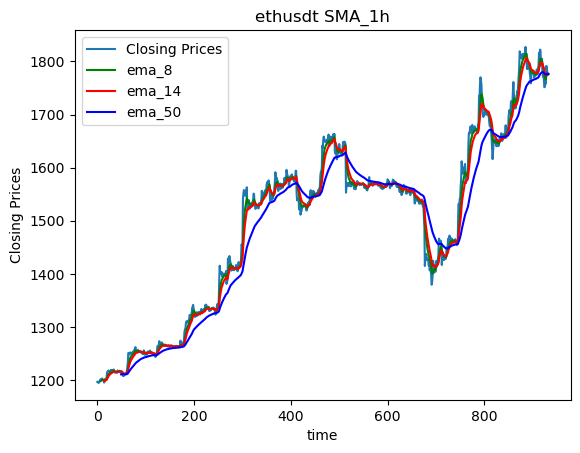

In [13]:
plt.title(symbol + ' SMA_' + str(interval))
plt.xlabel('time')
plt.ylabel('Closing Prices')
plt.plot(df.Close, label='Closing Prices')

plt.plot(df.ema_8, label='ema_8', c='g')
plt.plot(df.ema_14, label='ema_14', c='r')
plt.plot(df.ema_50, label='ema_50', c='b')
plt.legend()
plt.show()